# Distributional assumption -- The distribution includes biases!

Word vectors encode the linguistic contexts in which words appear. We can therefore ask how much linguistic bias -- which echoes societal biases -- is encoded in word vectors. Because much of web text is written by white, heterosexual North American men, as well as their Western European counterparts, the texts include biases that get encoded via distributional semantics methods.

Societal biases include, but are not exclusive to

* race
* ethnicity
* gender
* sexuality
* disabled status
* age
* intersections of all of these

We know that neural language models produce text that amplifies these biases. For example, recent studies suggest that neural language models and chat systems like ChatGPT have a predominantly "cool (white, affluent) mom" orientation toward social problems. The models in production today have lots of bumpers to prevent producing racist, sexist, etc. text.

For this, I will show you a cool projection method called "subspace" analysis, which produces a vector between two end-points.

One of the first places studying gender bias in word vectors was done was in [Bolukbası et al. (2016)](https://proceedings.neurips.cc/paper_files/paper/2016/file/a486cd07e4ac3d270571622f4f316ec5-Paper.pdf) who used a combination of:

* Static word vectors from `word2vec`
* Difference vectors between two "endpoints" of a binary spectrum (masculine <--> feminine)
* Principal components analysis over that endpoint
* The above steps produce a "gender subspace" vector
* Compute similarity between each vector for an occupation -- which can be biased toward different genders to different degrees, and verified with census data -- and the gender subspace vector

For our experiment, we will load in some vectors from `spaCy` and quantify the degree to which gender bias exists for some specific words:

```python
pairs = [
  ('he', 'she'),
  ('his', 'hers'),
  ('him', 'her'),
  ('his', 'her'),
  ('John', 'Mary'),
  ('himself', 'herself'),
  ('father', 'mother'),
  ('guy', 'gal'),
  ('boy', 'girl'),
  ('male', 'female')
]

pairs_japanese = [
    ('彼', '彼女'),  # he, she or boyfriend, girlfriend
    ('彼の', '彼女の'),  # his, her
    ('男性', '女性'),  # male, female
    ('男の子', '女の子'),  # boy, girl
    ('父', '母'),  # father, mother
]

pairs_spanish =  [
    ('él', 'ella'),  # he, she
    ('su', 'su'),     # his, her (Note: Spanish has the same word for his and her)
    ('hombre', 'mujer'),  # man, woman
    ('padre', 'madre'),   # father, mother
    ('niño', 'niña'),     # boy, girl
    ('actor', 'actriz'),  # actor (male), actress (female)
    ('rey', 'reina'),     # king, queen
    ('hermano', 'hermana')
]
# brother, sister

```

### Food for thought
* Can you think of other pairs of words that might be useful here? (brother, sister), (wife, husband), (doctor, nurse) ?
* What about other dimensions from one end to another might be able to use this method? age - young <--> old, first name last name
* How can these "endpoints" be used for answering questions other than bias? maybe it can look into 

In [16]:
# imports
from sklearn.preprocessing import normalize
import pandas as pd
import numpy as np

import spacy
! python -m spacy download en_core_web_md

nlp = spacy.load('en_core_web_md')

from sklearn.decomposition import TruncatedSVD # to project down into smaller dimension
from scipy.spatial.distance import cosine

from plotnine import *

from transformers import BertTokenizer, BertModel
import torch

from IPython.display import display

translations_sheet = pd.ExcelFile("../documents/iconicity_translations.xlsx")


# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
mBERT = BertModel.from_pretrained('bert-base-multilingual-cased')

import matplotlib.font_manager as fm

# Path to the Noto Sans CJK JP font file on your computer
font_path = "../Dancing_Script,Nanum_Brush_Script,Noto_Sans_JP,Rubik_Iso,Style_Script,etc/Noto_Sans_JP/NotoSansJP-VariableFont_wght.ttf"

font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)

if font_name in [f.name for f in fm.fontManager.ttflist]:
    print(f"Font '{font_name}' successfully registered with Matplotlib.")
else:
    print(f"Failed to register font '{font_name}' with Matplotlib.")

pairs_japanese = [
    ('彼', '彼女'),  # he, she or boyfriend, girlfriend
    ('彼の', '彼女の'),  # his, her
    ('男性', '女性'),  # male, female
    ('男の子', '女の子'),  # boy, girl
    ('父', '母'),  # father, mother
]


job_title_mapping = {
    "女優": "actress",
    "アーティスト": "artist",
    "弁護士": "attorney",
    "ベビーシッター": "babysitter",
    "ボス": "boss",
    "ビジネスマン": "businessman",
    "実業家": "businesswoman",
    "大工": "carpenter",
    "シェフ": "chef",
    "コーチ": "coach",
    "警官": "police officer",
    "踊り子": "dancer",
    "探偵": "detective",
    "医者": "doctor",
    "運転者": "driver",
    "消防士": "firefighter",
    "庭師": "gardener",
    "ガード": "guard / security guard / bouncer",
    "お手伝いさん": "cleaner / housekeeper / maid",
    "管理人": "janitor",
    "裁判官": "judge",
    "王": "king",
    "弁護士": "lawyer",
    "図書館員": "librarian",
    "中尉": "lieutenant",
    "メイド": "maid",
    "郵便配達員": "mailman",
    "マネージャー": "manager",
    "メカニック": "mechanic",
    "看護師": "nurse",
    "パイロット": "pilot",
    "社長": "president",
    "王子": "prince",
    "お姫様": "princess",
    "囚人": "prisoner",
    "教授": "professor",
    "精神科医": "psychiatrist",
    "女王": "queen",
    "秘書": "secretary / assistant",
    "シェリフ": "sheriff",
    "兵士": "soldier",
    "学生": "student",
    "教師": "teacher",
    "泥棒": "thief",
    "ウェイター": "waiter",
    "ウェイトレス": "waitress",
    "ライター": "writer"
}

english_to_japanese = {
   "actress": "女優",
    "artist": "アーティスト",
    "attorney": "弁護士",
    "babysitter": "ベビーシッター",
    "boss": "ボス",
    "businessman": "ビジネスマン",
    "businesswoman": "実業家",
    "carpenter": "大工",
    "chef": "シェフ",
    "coach": "コーチ",
    "police officer": "警官",
    "dancer": "踊り子",
    "detective": "探偵",
    "doctor": "医者",
    "driver": "運転者",
    "firefighter": "消防士",
    "gardener": "庭師",
    "guard / security guard / bouncer": "ガード",
    "cleaner / housekeeper / maid": "お手伝いさん",
    "janitor": "管理人",
    "judge": "裁判官",
    "king": "王",
    "lawyer": "弁護士",
    "librarian": "図書館員",
    "lieutenant": "中尉",
    "maid": "メイド",
    "mailman": "郵便配達員",
    "manager": "マネージャー",
    "mechanic": "メカニック",
    "nurse": "看護師",
    "pilot": "パイロット",
    "president": "社長",
    "prince": "王子",
    "princess": "お姫様",
    "prisoner": "囚人",
    "professor": "教授",
    "psychiatrist": "精神科医",
    "queen": "女王",
    "secretary / assistant": "秘書",
    "sheriff": "シェリフ",
    "soldier": "兵士",
    "student": "学生",
    "teacher": "教師",
    "thief": "泥棒",
    "waiter": "ウェイター",
    "waitress": "ウェイトレス",
    "writer": "ライター"
}

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.7.1/en_core_web_md-3.7.1-py3-none-any.whl (42.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
Font 'Noto Sans JP' successfully registered with Matplotlib.


## Get occupations

There are lots of ways to get career or occupational bias. Here, we download a dataset that has lots of different biases -- gender, race, ethnicity -- and was used to study bias in GPT-2. We can check that the Bolukbası method correlates with:

- The gender bias in US Census data
- The gender bias that GPT-2 produces

https://github.com/oxai/intersectional_gpt2

Data:
https://github.com/oxai/intersectional_gpt2/blob/master/data/GPT-2/US_data/us_rows_data.csv

In [17]:
# upload the file
df = pd.read_csv("../documents/gpt_vs_us_data.csv")
df.head()

# us_white_F is average bias in the census for white women
# gpt_white_F is the average bias produced by GPT-2

,job,gpt_asian_F,gpt_asian_M,gpt_black_F,gpt_black_M,gpt_hispanic_F,gpt_hispanic_M,gpt_white_F,gpt_white_M,gpt_base_F,...,diff_asian_F,diff_asian_M,diff_black_F,diff_black_M,diff_hispanic_F,diff_hispanic_M,diff_white_F,diff_white_M,diff_base_F,diff_base_M
0,babysitter,0.00,0.00,12.49,0.00,25.81,0.00,96.41,0.00,94.00,...,-3.08,-0.22,-3.76,-1.15,2.83,-1.62,25.43,-5.02,0.60,-6.60
1,secretary / assistant,4.03,1.52,8.09,2.09,7.94,4.48,68.66,47.77,66.27,...,0.77,1.28,-0.01,1.49,-4.55,3.57,-10.75,41.98,-26.93,24.47
2,receptionist,4.15,1.65,6.01,2.09,17.87,8.95,46.74,13.18,70.50,...,0.05,1.16,-7.74,0.44,-1.60,6.62,-20.95,5.07,-18.80,15.80
3,cleaner / housekeeper / maid,5.38,3.50,8.65,3.81,9.93,5.75,35.93,15.48,76.14,...,1.73,3.05,-6.84,1.89,-33.86,0.33,-28.32,7.54,-12.86,9.14
4,nurse,4.15,0.55,9.71,2.09,16.54,2.98,67.19,9.88,83.66,...,-4.02,-0.47,-1.31,0.71,10.14,2.19,-0.28,1.46,-5.24,0.56


In [18]:
def extract_row(frame, field): # extract all data from a specific row in frame
    result = []
    for i, row in frame.iterrows():
      row_val = row[field]
      val_split = row_val.split("/") # some data entries have multiple names separated by a "/"
      for vals in val_split:
        result.append(vals.strip()) # append to result array
    return result

In [19]:
jobs = extract_row(df, "job")
jobs

['babysitter',
 'secretary',
 'assistant',
 'receptionist',
 'cleaner',
 'housekeeper',
 'maid',
 'nurse',
 'social worker',
 'teacher',
 'model',
 'writer',
 'barista',
 'bartender',
 'photographer',
 'bus driver',
 'reporter',
 'journalist',
 'cook',
 'doctor',
 'manager',
 'janitor',
 'lawyer',
 'barber',
 'chef',
 'guard',
 'security guard',
 'bouncer',
 'courier',
 'computer programmer',
 'police officer',
 'taxi driver',
 'chauffeur',
 'driver',
 'truck driver',
 'construction worker',
 'laborer',
 'carpenter',
 'plumber',
 'mechanic',
 'salesperson']

In [48]:

# get word embeddings from mBERT and create endpoints
def parse_sheet(sheet, category):
    this_df = pd.read_excel(translations_sheet, sheet_name = sheet)
    words = []
    # Loop through the DataFrame rows
    for index, row in this_df.iterrows():
        # Check if the 'categories' column matches the specified category
        if row['category'] == category:
            # Get the word from the column after 'categories'
            word = row[2]  # Assuming the words are in the second column
            # Check if the word is not null or blank
            if pd.notna(word) and word.strip():
                words.append(word.strip())
    return words 


    
    
def mBERT_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = mBERT(**inputs)
    # Take the mean of the embeddings across the token sequence to get a single embedding vector
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy().reshape(1,-1)
    
def mBERT_endpoints(pairs): # get difference vectors between pairs, create endpoints
    endpoints = [normalize(mBERT_embeddings(x).reshape(1, -1) - mBERT_embeddings(y).reshape(1, -1))[0] for x, y in pairs] #model(x) gets word embeddings from model
    return endpoints

def compute_mBERT_vectors(words): # get unit circle vectors
    uc_vectors = [normalize(mBERT_embeddings(word)).flatten() for word in words]
    return uc_vectors

def pca_project(components, endpoints):
    pca = TruncatedSVD(n_components=components) # one gender dimension
    pca.fit(endpoints)
    return pca

def compute_bias(pca_sub, vectors, words):
    return list(zip(pca_sub.transform(vectors).flatten(), words))

def create_df(bias_words, columns_list):
    return pd.DataFrame(bias_words, columns = columns_list)

def vectors_to_english(mappings, vectors):
    result = []
    
    for s in vectors:
        pair = list(s)
        if pair[1] in mappings:
            pair[1] = mappings[pair[1]]
            result.append(tuple(pair))
    return result

def correlation_plot(df_one, df_two, x_axis, y_axis, label, x_axisName, y_axisName):
    plot = (ggplot(df_one.merge(df_two),
       aes(x=x_axis, y=y_axis, label=label)) + geom_label() + theme_bw()
       + xlab(x_axisName)
       + ylab(y_axisName))
    return plot.draw()

def correlation_bounded_plot(df_one, df_two, x_axis, y_axis, label, x_axisName, y_axisName, x_bounds):
    plot = (ggplot(df_one.merge(df_two),
       aes(x=x_axis, y=y_axis, label=label)) + geom_label() + theme_bw()
       + xlab(x_axisName)
       + ylab(y_axisName)
       + xlim(x_bounds))
    return plot.draw()

In [59]:
def bolukbasi_correlation(pairs, language, category, mappings):
    words_list = parse_sheet(language, category) # get language words in a list
    # print(words_list)
    language_endpoints = mBERT_endpoints(pairs)
    # print(language_endpoints)
    pca_subspace = pca_project(1, language_endpoints)
    category_vectors = compute_mBERT_vectors(words_list)
    
    bias_vectors = compute_bias(pca_subspace, category_vectors, words_list)
    print(bias_vectors)
    translated_vectors = vectors_to_english(mappings, bias_vectors)
    bias_df = create_df(translated_vectors, ["bias", "job"]) # have to make columns generic
    display(bias_df)
    df_min = bias_df["bias"].min()
    df_max = bias_df["bias"].max()
    merged_df = bias_df.merge(df)
    return correlation_plot(bias_df, df, "bias", "gpt_white_F", "job", "Japanese Job Bias", "GPT vector bias") # need to make generic

    
    
    
    
    
    

/var/folders/qq/jgwbs7g96vg0f8xbyhzvw3000000gn/T/ipykernel_52839/3530254940.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


[(0.031190183, '俳優'), (-0.12368637, '女優'), (0.053306125, 'アーティスト'), (-0.056563456, '弁護士'), (-0.06849745, 'ベビーシッター'), (0.025843576, 'ボス'), (-0.10327741, 'ビジネスマン'), (-0.06478012, '実業家'), (-0.07578256, '大工'), (-0.093747295, 'シェフ'), (0.08413961, 'コーチ'), (0.023973115, '警官'), (-0.032177188, '踊り子'), (-0.105645016, '探偵'), (-0.014570348, '医者'), (0.05605439, '運転者'), (-0.047798105, '消防士'), (-0.1863429, '庭師'), (-0.044926148, 'ガード'), (-0.09948844, 'お手伝いさん'), (-0.04668965, '管理人'), (0.046795778, '裁判官'), (0.08418657, '王'), (-0.056563456, '弁護士'), (-0.015450342, '図書館員'), (-0.0071161687, '中尉'), (-0.032004073, 'メイド'), (-0.018845152, '郵便配達員'), (0.060039416, 'マネージャー'), (-0.101232186, 'メカニック'), (-0.19331497, '看護師'), (0.10313441, 'パイロット'), (0.019468825, '社長'), (0.06253404, '王子'), (-0.08374881, 'お姫様'), (-0.07163715, '囚人'), (0.0955837, '教授'), (-0.16306739, '精神科医'), (-0.051891074, '女王'), (0.009703137, '秘書'), (-0.037024584, 'シェリフ'), (0.0616635, '兵士'), (0.1265114, '学生'), (-0.06437507, '教師'), (-0.047174253, '泥棒'), 

,bias,job
0,-0.123686,actress
1,0.053306,artist
2,-0.056563,lawyer
3,-0.068497,babysitter
4,0.025844,boss
5,-0.103277,businessman
6,-0.064780,businesswoman
7,-0.075783,carpenter
8,-0.093747,chef
9,0.084140,coach


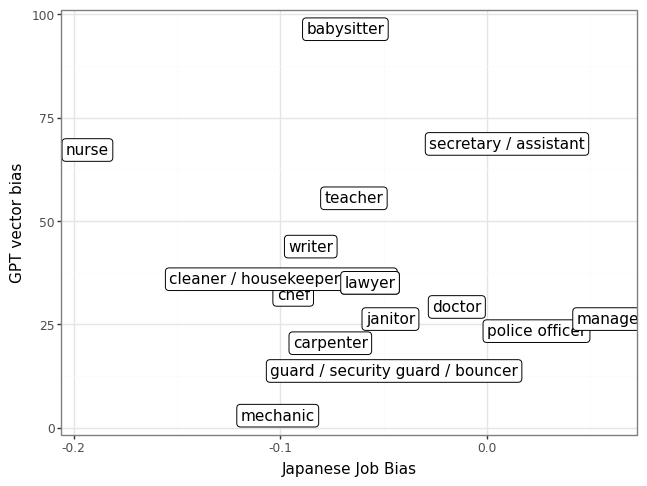

In [60]:
bolukbasi_correlation(pairs_japanese, "Japanese", "professions", job_title_mapping)